# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [ ]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

In [ ]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [2]:
#!L

import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:1'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [3]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [4]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.65it/s]


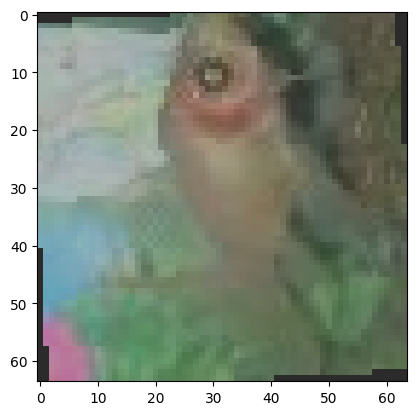

In [5]:
from matplotlib import pyplot as plt

plt.imshow(train_dataset[0][0].transpose(2, 0))

Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image
from tiny_img_dataset import read_rgb_image


class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([label for name, label in annotations])))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = read_rgb_image(img_name)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [7]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3218.96it/s]


For the most cases the default `DataLoader` will be good enough.

In [8]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

In [9]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [11]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        return self.nn(x)
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(
                f'ConvBNRelu_{block_index}_{layer_index_in_block}', 
                ConvBNRelu(in_channels, out_channels, kernel_size=3)
            )
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [12]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [13]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [14]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [15]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [16]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|                                                                                                                                        | 0/1563 [00:00<?, ?it/s]/home/dsorokin/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 93.55it/s]


Epoch 1 of 30 took 18.094s
  training loss (in-iteration): 	4.469502
  validation accuracy: 			11.15 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.90it/s]


Epoch 2 of 30 took 18.028s
  training loss (in-iteration): 	3.782109
  validation accuracy: 			16.78 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.31it/s]


Epoch 3 of 30 took 18.052s
  training loss (in-iteration): 	3.460393
  validation accuracy: 			22.13 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 92.98it/s]


Epoch 4 of 30 took 18.223s
  training loss (in-iteration): 	3.251307
  validation accuracy: 			26.27 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.64it/s]


Epoch 5 of 30 took 17.960s
  training loss (in-iteration): 	3.100552
  validation accuracy: 			29.00 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.63it/s]


Epoch 6 of 30 took 18.212s
  training loss (in-iteration): 	2.978552
  validation accuracy: 			29.74 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:17<00:00, 90.47it/s]


Epoch 7 of 30 took 18.791s
  training loss (in-iteration): 	2.883075
  validation accuracy: 			30.77 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 92.44it/s]


Epoch 8 of 30 took 18.500s
  training loss (in-iteration): 	2.802396
  validation accuracy: 			32.03 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 92.62it/s]


Epoch 9 of 30 took 18.348s
  training loss (in-iteration): 	2.732419
  validation accuracy: 			34.36 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 92.64it/s]


Epoch 10 of 30 took 18.353s
  training loss (in-iteration): 	2.676451
  validation accuracy: 			35.43 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 93.77it/s]


Epoch 11 of 30 took 18.158s
  training loss (in-iteration): 	2.622781
  validation accuracy: 			36.12 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.71it/s]


Epoch 12 of 30 took 18.014s
  training loss (in-iteration): 	2.577805
  validation accuracy: 			35.13 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 98.87it/s]


Epoch 13 of 30 took 17.364s
  training loss (in-iteration): 	2.536866
  validation accuracy: 			36.66 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.93it/s]


Epoch 14 of 30 took 17.836s
  training loss (in-iteration): 	2.499051
  validation accuracy: 			37.11 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.19it/s]


Epoch 15 of 30 took 18.124s
  training loss (in-iteration): 	2.467254
  validation accuracy: 			37.84 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:15<00:00, 98.34it/s]


Epoch 16 of 30 took 17.218s
  training loss (in-iteration): 	2.434910
  validation accuracy: 			38.73 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.06it/s]


Epoch 17 of 30 took 17.973s
  training loss (in-iteration): 	2.404147
  validation accuracy: 			37.57 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 96.58it/s]


Epoch 18 of 30 took 17.605s
  training loss (in-iteration): 	2.377878
  validation accuracy: 			38.43 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 95.66it/s]


Epoch 19 of 30 took 17.677s
  training loss (in-iteration): 	2.349808
  validation accuracy: 			39.12 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.91it/s]


Epoch 20 of 30 took 17.821s
  training loss (in-iteration): 	2.325526
  validation accuracy: 			40.36 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 95.62it/s]


Epoch 21 of 30 took 17.760s
  training loss (in-iteration): 	2.303117
  validation accuracy: 			40.62 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.21it/s]


Epoch 22 of 30 took 17.980s
  training loss (in-iteration): 	2.283533
  validation accuracy: 			39.42 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 95.79it/s]


Epoch 23 of 30 took 17.649s
  training loss (in-iteration): 	2.266288
  validation accuracy: 			40.67 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 95.25it/s]


Epoch 24 of 30 took 17.811s
  training loss (in-iteration): 	2.246840
  validation accuracy: 			41.13 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 92.84it/s]


Epoch 25 of 30 took 18.361s
  training loss (in-iteration): 	2.228184
  validation accuracy: 			40.65 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.21it/s]


Epoch 26 of 30 took 18.204s
  training loss (in-iteration): 	2.205760
  validation accuracy: 			39.73 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 97.16it/s]


Epoch 27 of 30 took 17.590s
  training loss (in-iteration): 	2.195446
  validation accuracy: 			41.38 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 94.98it/s]


Epoch 28 of 30 took 18.026s
  training loss (in-iteration): 	2.175064
  validation accuracy: 			41.62 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 95.37it/s]


Epoch 29 of 30 took 17.715s
  training loss (in-iteration): 	2.156053
  validation accuracy: 			41.94 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:16<00:00, 93.50it/s]


Epoch 30 of 30 took 18.228s
  training loss (in-iteration): 	2.147047
  validation accuracy: 			41.58 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [17]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(inplace=True)
            
        # conv2 with stride=1 like in https://pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        
        if self.conv3 is not None:
            x = self.conv3(x)

        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            padding = 1 if i != 0 and j == 0 else 'same'
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(
                f'ResNetBlock2_{i}_{j}',
                ResNetBlock2(in_channels, out_channels, stride=stride, padding=padding)
            )
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [18]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.19it/s]


Epoch 1 of 30 took 24.094s
  training loss (in-iteration): 	4.869542
  validation accuracy: 			8.29 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.38it/s]


Epoch 2 of 30 took 23.541s
  training loss (in-iteration): 	4.118836
  validation accuracy: 			15.14 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.92it/s]


Epoch 3 of 30 took 23.384s
  training loss (in-iteration): 	3.656131
  validation accuracy: 			21.14 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 73.61it/s]


Epoch 4 of 30 took 23.064s
  training loss (in-iteration): 	3.355471
  validation accuracy: 			20.89 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.59it/s]


Epoch 5 of 30 took 23.667s
  training loss (in-iteration): 	3.141688
  validation accuracy: 			28.71 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.09it/s]


Epoch 6 of 30 took 24.318s
  training loss (in-iteration): 	2.981749
  validation accuracy: 			29.04 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.88it/s]


Epoch 7 of 30 took 24.215s
  training loss (in-iteration): 	2.845360
  validation accuracy: 			33.71 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.93it/s]


Epoch 8 of 30 took 23.357s
  training loss (in-iteration): 	2.729793
  validation accuracy: 			35.07 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.46it/s]


Epoch 9 of 30 took 23.191s
  training loss (in-iteration): 	2.634462
  validation accuracy: 			36.72 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.55it/s]


Epoch 10 of 30 took 23.469s
  training loss (in-iteration): 	2.550126
  validation accuracy: 			34.43 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 73.07it/s]


Epoch 11 of 30 took 22.974s
  training loss (in-iteration): 	2.473954
  validation accuracy: 			38.64 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.36it/s]


Epoch 12 of 30 took 23.245s
  training loss (in-iteration): 	2.407444
  validation accuracy: 			38.29 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.61it/s]


Epoch 13 of 30 took 23.499s
  training loss (in-iteration): 	2.354141
  validation accuracy: 			40.27 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.64it/s]


Epoch 14 of 30 took 23.422s
  training loss (in-iteration): 	2.300096
  validation accuracy: 			40.44 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.38it/s]


Epoch 15 of 30 took 23.473s
  training loss (in-iteration): 	2.247137
  validation accuracy: 			39.84 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.24it/s]


Epoch 16 of 30 took 23.575s
  training loss (in-iteration): 	2.202287
  validation accuracy: 			40.96 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.15it/s]


Epoch 17 of 30 took 23.304s
  training loss (in-iteration): 	2.165120
  validation accuracy: 			41.88 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.70it/s]


Epoch 18 of 30 took 23.713s
  training loss (in-iteration): 	2.126891
  validation accuracy: 			40.52 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 73.47it/s]


Epoch 19 of 30 took 22.949s
  training loss (in-iteration): 	2.084246
  validation accuracy: 			43.22 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.45it/s]


Epoch 20 of 30 took 23.293s
  training loss (in-iteration): 	2.047158
  validation accuracy: 			42.40 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.71it/s]


Epoch 21 of 30 took 23.102s
  training loss (in-iteration): 	2.017078
  validation accuracy: 			43.15 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.00it/s]


Epoch 22 of 30 took 23.992s
  training loss (in-iteration): 	1.987942
  validation accuracy: 			43.36 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.26it/s]


Epoch 23 of 30 took 23.949s
  training loss (in-iteration): 	1.957264
  validation accuracy: 			42.31 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.16it/s]


Epoch 24 of 30 took 24.062s
  training loss (in-iteration): 	1.932101
  validation accuracy: 			43.52 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.63it/s]


Epoch 25 of 30 took 23.144s
  training loss (in-iteration): 	1.899193
  validation accuracy: 			43.57 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.27it/s]


Epoch 26 of 30 took 23.230s
  training loss (in-iteration): 	1.872121
  validation accuracy: 			43.50 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 73.46it/s]


Epoch 27 of 30 took 23.106s
  training loss (in-iteration): 	1.854697
  validation accuracy: 			43.94 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.09it/s]


Epoch 28 of 30 took 23.663s
  training loss (in-iteration): 	1.822994
  validation accuracy: 			44.09 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.24it/s]


Epoch 29 of 30 took 23.812s
  training loss (in-iteration): 	1.799882
  validation accuracy: 			43.98 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.44it/s]


Epoch 30 of 30 took 23.633s
  training loss (in-iteration): 	1.781726
  validation accuracy: 			43.44 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [19]:
vgg_model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
vgg_model = vgg_model.to(device)
opt = torch.optim.Adam(vgg_model.parameters())
train_loop(vgg_model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.52it/s]


Epoch 1 of 30 took 23.461s
  training loss (in-iteration): 	4.764960
  validation accuracy: 			6.33 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.52it/s]


Epoch 2 of 30 took 23.452s
  training loss (in-iteration): 	4.269277
  validation accuracy: 			10.82 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.23it/s]


Epoch 3 of 30 took 23.548s
  training loss (in-iteration): 	3.967948
  validation accuracy: 			14.34 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.38it/s]


Epoch 4 of 30 took 23.442s
  training loss (in-iteration): 	3.721783
  validation accuracy: 			17.74 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.78it/s]


Epoch 5 of 30 took 24.184s
  training loss (in-iteration): 	3.523248
  validation accuracy: 			21.24 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.69it/s]


Epoch 6 of 30 took 24.054s
  training loss (in-iteration): 	3.361662
  validation accuracy: 			19.58 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.51it/s]


Epoch 7 of 30 took 23.775s
  training loss (in-iteration): 	3.222265
  validation accuracy: 			22.15 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.84it/s]


Epoch 8 of 30 took 23.761s
  training loss (in-iteration): 	3.114687
  validation accuracy: 			26.87 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.64it/s]


Epoch 9 of 30 took 23.720s
  training loss (in-iteration): 	3.011091
  validation accuracy: 			29.71 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 71.04it/s]


Epoch 10 of 30 took 23.524s
  training loss (in-iteration): 	2.918905
  validation accuracy: 			29.51 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.92it/s]


Epoch 11 of 30 took 24.151s
  training loss (in-iteration): 	2.839278
  validation accuracy: 			31.30 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.39it/s]


Epoch 12 of 30 took 23.799s
  training loss (in-iteration): 	2.763940
  validation accuracy: 			32.01 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.96it/s]


Epoch 13 of 30 took 23.675s
  training loss (in-iteration): 	2.698768
  validation accuracy: 			34.02 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.62it/s]


Epoch 14 of 30 took 23.685s
  training loss (in-iteration): 	2.631012
  validation accuracy: 			35.48 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.17it/s]


Epoch 15 of 30 took 23.886s
  training loss (in-iteration): 	2.576541
  validation accuracy: 			34.50 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.46it/s]


Epoch 16 of 30 took 23.490s
  training loss (in-iteration): 	2.523587
  validation accuracy: 			36.39 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.21it/s]


Epoch 17 of 30 took 23.574s
  training loss (in-iteration): 	2.477007
  validation accuracy: 			37.76 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.54it/s]


Epoch 18 of 30 took 23.859s
  training loss (in-iteration): 	2.420669
  validation accuracy: 			37.05 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.60it/s]


Epoch 19 of 30 took 23.394s
  training loss (in-iteration): 	2.380499
  validation accuracy: 			37.64 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.63it/s]


Epoch 20 of 30 took 23.590s
  training loss (in-iteration): 	2.337534
  validation accuracy: 			38.38 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.85it/s]


Epoch 21 of 30 took 23.648s
  training loss (in-iteration): 	2.299404
  validation accuracy: 			35.59 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.94it/s]


Epoch 22 of 30 took 23.677s
  training loss (in-iteration): 	2.261561
  validation accuracy: 			39.52 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.69it/s]


Epoch 23 of 30 took 23.572s
  training loss (in-iteration): 	2.226845
  validation accuracy: 			38.60 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.17it/s]


Epoch 24 of 30 took 23.571s
  training loss (in-iteration): 	2.196401
  validation accuracy: 			38.99 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 72.31it/s]


Epoch 25 of 30 took 23.126s
  training loss (in-iteration): 	2.162805
  validation accuracy: 			40.17 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.82it/s]


Epoch 26 of 30 took 23.988s
  training loss (in-iteration): 	2.133315
  validation accuracy: 			39.42 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.14it/s]


Epoch 27 of 30 took 23.609s
  training loss (in-iteration): 	2.101420
  validation accuracy: 			40.62 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.39it/s]


Epoch 28 of 30 took 23.355s
  training loss (in-iteration): 	2.077266
  validation accuracy: 			40.61 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 70.16it/s]


Epoch 29 of 30 took 23.943s
  training loss (in-iteration): 	2.045026
  validation accuracy: 			40.62 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:22<00:00, 69.65it/s]


Epoch 30 of 30 took 24.044s
  training loss (in-iteration): 	2.018830
  validation accuracy: 			41.59 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [20]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.43441480891719747


In [21]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = transformations(X_batch).to(device)
                logits = model(X_batch_transformed)
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.stack(logits_per_transform, dim=0).mean(dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [22]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

In [23]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.80it/s]


Model accuracy with 3 forward runs is 0.4534235668789809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Model accuracy with 5 forward runs is 0.4565087579617834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.61it/s]


Model accuracy with 7 forward runs is 0.45849920382165604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:39<00:00,  3.98it/s]


Model accuracy with 9 forward runs is 0.459593949044586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:53<00:00,  2.95it/s]


Model accuracy with 13 forward runs is 0.4611863057324841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:01<00:00,  2.55it/s]

Model accuracy with 15 forward runs is 0.46009156050955413


Let's visualize what we have computed

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

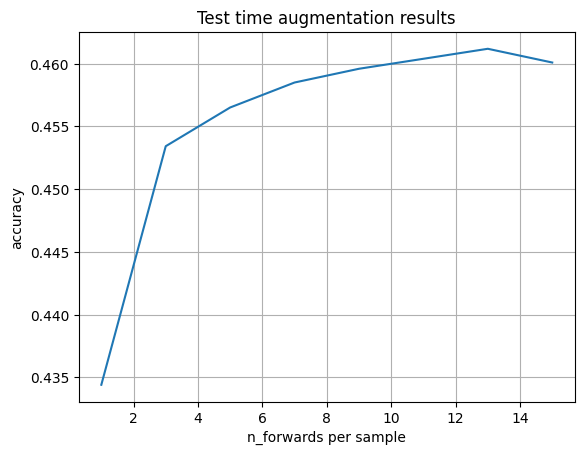

In [25]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape